## Why Areas of Interest (AOI)?
Eye Tracking Data is often analysed with respect to **Areas of Interest** - AOIs.
AOIs define regions in a scenery that are of particular relevance for the researcher, such as a specific product, an image or a face.

Here, we want to demonstrate how you can mark areas of interest, and compute different metrics, such as fixation duration or time to first contact. We will rely on data generated with the **reference image mapper**, but similar approaches are feasible with a marker mapper-based approach.

At the end of this little hands-on guide, you will have learned how to:

- show gaze and fixation data overlayed on the reference image
- mark areas of interest on the reference image
- match gaze samples to areas of interest
- compute hit rates, time to first fixation and total dwell time
- analyze spatially distributed AOIs

## Import the reference image
First, we load and display the reference image. We'll use matplotlib for plotting and the cv2 library to load the image. The folder with the files generated from the reference image mapper enrichment should be located in the same directory from which you are also executing this code.

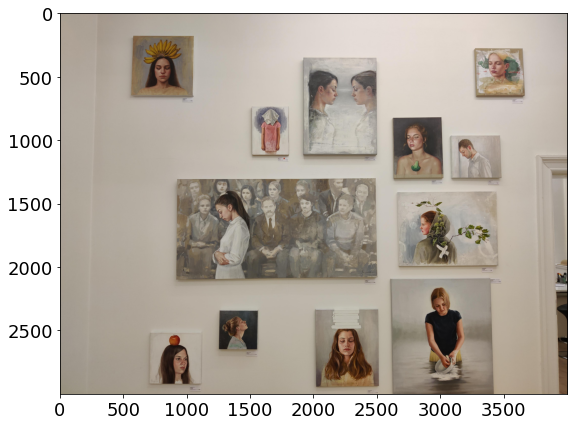

In [4]:
import cv2
import matplotlib.pyplot as plt
# larger labels are nicer to read
plt.rcParams.update({'font.size': 18})

# define the path on your own PC
path_to_reference_image_mapper = "./Art-_Gallery_Picture_Viewing_REFERENCE-IMAGE-MAPPER_multiple_paintings_standing_csv"

image_fig, image_axs = plt.subplots(1,1, figsize = (10,7))
reference_image = cv2.imread(f"{path_to_reference_image_mapper}/reference_image.jpeg")
# convert color format to RGB
reference_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)

image_axs.imshow(reference_image);

## Import the fixation data
To show fixations on top of the image, we need to import the respective datafiles from the reference image mapper folder. 

The data is stored as a csv table, and we use pandas to load the file as a dataframe.

In [5]:
import pandas as pd

fixations = pd.read_csv(f"{path_to_reference_image_mapper}/fixations.csv")
fixations.head()

,section id,recording id,fixation id,start timestamp [ns],end timestamp [ns],duration [ms],fixation detected in reference image,fixation x [px],fixation y [px]
0,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,248,1636035560036503914,1636035560228482914,191,True,2410.0,2134.0
1,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,249,1636035560256651914,1636035560476503914,219,True,2224.0,1717.0
2,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,250,1636035560500491914,1636035560728557914,228,True,2431.0,1560.0
3,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,251,1636035560776494914,1636035560968578914,192,True,1936.0,1118.0
4,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,252,1636035561008557914,1636035561148511914,139,True,2826.0,1668.0


Now we can see which data the fixation file contains: besides the section and recording id, which are specific to individual subjects and enrichment sections, we get:
- **fixation id**: an ID for each fixation, 
- **start timestamp [ns]**: the time when this fixation started  
- **end timestamp [ns]**: the time when this fixation ended
- **duration [ms]**: the duration of the fixation 
- **fixation detected in reference image**: if the fixation was inside the reference image
- **fixation x [px]**: x-coordinate of the fixation relative to the reference image 
- **fixation y [px]**: y coordinate of the fixation relative to the reference image


## Plot the fixation data and the reference image
In the next step, we can visualise these information by overlaying the fixation position on the reference image:

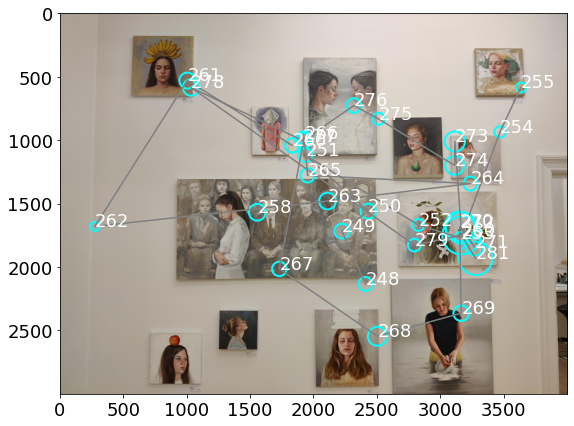

In [6]:
# we choose one section as an example, to avoid cluttering more than one participant
import numpy as np
example_section = np.unique(fixations['section id'])[0]

example_fixations = fixations[fixations['section id'] == example_section]

fixation_fig, fixation_axs = plt.subplots(1,1, figsize = (10,7))
# show the reference image as above
fixation_axs.imshow(np.asarray(reference_image))
# plot fixations at their x- and y-position
fixation_axs.scatter(example_fixations['fixation x [px]'],
                     example_fixations['fixation y [px]'],
                     # change the face- and edgecolor to get circles rather than dots
                     facecolor='none', edgecolor='cyan', linewidth=2, 
                     # set the size of the circles relative to the duration of each fixation
                     s = example_fixations['duration [ms]']);
# ennumerate the fixations
for fix_id, x, y in zip(example_fixations['fixation id'],
                        example_fixations['fixation x [px]'], 
                        example_fixations['fixation y [px]']
                       ):
        fixation_axs.annotate(fix_id, [x, y], color = 'white')
# add lines that connect the fixations in the order in which they occurred
fixation_axs.plot(example_fixations['fixation x [px]'], example_fixations['fixation y [px]'], 
                  color='grey');

Inspecting the data like this is important - it gives you a rough idea how the data looks like, and it can already indicate potential problems with the data. Note, for example, how the fixations *268* and *269* on the two lower right paintings is to the right of the face in each of them. That's odd - we'd expect our participants to look at faces, rather than staring into the void. This can be a sign of a poorly chosen offset correction during the recording. 

If in this case, we were interested at how people explore faces in the paintings, we might need to correct this before continuing our analysis.

## Marking areas of interest

In the next step, we will mark our areas of interest on the reference image. In this case, we define each image in the picture as an area of interest

In [7]:
# resize the image before labelling aois makes the image stay in the screen boundaries
scaling_factor = 0.25
scaled_image = reference_image.copy()
scaled_image = cv2.resize(scaled_image, 
                             dsize = None, 
                             fx = scaling_factor, 
                             fy = scaling_factor)

In [8]:
scaled_aois = cv2.selectROIs("AOI Annotation", scaled_image);
cv2.destroyAllWindows();

# scale back the position of AOIs
aois = scaled_aois / scaling_factor
print(scaled_aois)

[[141  44 124 119]
 [376 183  77  98]
 [476  86 153 194]
 [654 205 102 121]
 [766 240 105  86]
 [811  65 107 100]
 [226 324 401 199]
 [660 351 205 151]
 [177 626 105 106]
 [314 585  77  78]
 [500 580 131 157]
 [649 523 209 227]]


## Overlaying Areas of Interest on the Reference Image

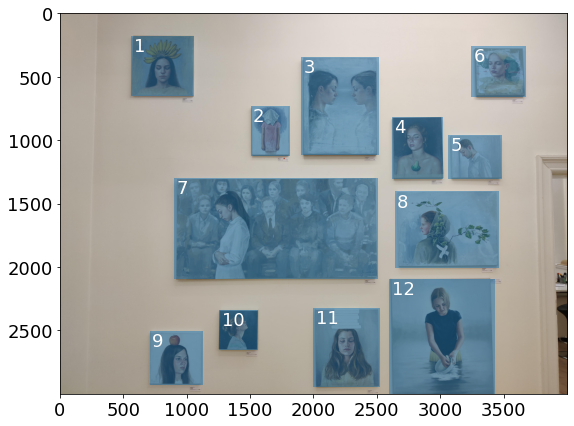

In [9]:
import matplotlib.patches as patches

# List the painting ids as names 
paintings = [idx + 1 for idx in range(len(aois))]

# plot the reference image and overlay the AOIS
fig, ax = plt.subplots(1,1, figsize = (10,7))
ax.imshow(np.asarray(reference_image))
for idx, aoi in enumerate(aois):
    ax.add_patch(patches.Rectangle(aoi, *aoi[2:], alpha=0.5))
    ax.text(aoi[0] + 20, aoi[1] + 120, f"{idx + 1}", color="white")
ax.grid(False)

If you notice after looking at the overlay that some AOIs are not placed correctly, you can manually manipulate the location by changing entries in the aoi array.

## Detecting fixations inside the areas of interest. 

Next up, we want to match the fixation coordinates to the Areas of Interest. This is comparable to asking for every x/y coordinate pair that defines a fixation if that pair is inside any of the rectangles.

In [10]:
def check_in_rect(fixation_data, rectangle_coordinates):
    
    rect_x, rect_y, rect_width, rect_height = rectangle_coordinates
        
    x_hit = fixation_data['fixation x [px]'].between(rect_x, rect_x+rect_width) 
    y_hit = fixation_data['fixation y [px]'].between(rect_y, rect_y+rect_height)
    
    in_rect_idx = x_hit & y_hit
    
    return(in_rect_idx)
        
fixations['AOI'] = None

for aoi_id, aoi in enumerate(aois):
    fixations.loc[check_in_rect(fixations, aoi), 'AOI'] = paintings[aoi_id]

fixations.head()

,section id,recording id,fixation id,start timestamp [ns],end timestamp [ns],duration [ms],fixation detected in reference image,fixation x [px],fixation y [px],AOI
0,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,248,1636035560036503914,1636035560228482914,191,True,2410.0,2134.0,None
1,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,249,1636035560256651914,1636035560476503914,219,True,2224.0,1717.0,7
2,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,250,1636035560500491914,1636035560728557914,228,True,2431.0,1560.0,7
3,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,251,1636035560776494914,1636035560968578914,192,True,1936.0,1118.0,3
4,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,252,1636035561008557914,1636035561148511914,139,True,2826.0,1668.0,8


You can now see the new column "AOI" - this column contains the information if the gaze fell inside a given area of interest. E.g. Fixation 219 (the second entry) was made on AOI 7.

## Extracting Metrics
Marking areas of interest and matching them with fixations helps us get a first visual impression of the data. But if we want to compare areas of interest with each other we need to quantify some metrics. 

We will show you here how to compute 3 common metrics: 
- AOI Hit Rate
- Time to first Fixation
- Dwell Time

### AOI Hit Rate

The Hit Rate of an AOI is defined as the proportion of subjects that looked at the AOI at least once. 
A Hit Rate of 100% means, every person we recorded looked at the AOI, a Hit Rate of 50% indicates that only every second person looked at the AOI, etc.

In [36]:
# first, we extract the hit count
fixation_counts = fixations.pivot_table(index = 'section id', 
                      columns = 'AOI',
                      values = 'fixation id',
                      fill_value = 0, 
                      aggfunc = 'count').unstack().to_frame().rename(columns = {0:'fixation count'})
fixation_counts.reset_index(inplace = True)

# and boil it down to yes/no
hits = fixation_counts.copy()
hits['hit'] = hits['fixation count']>0

hits.head()

,AOI,section id,fixation count,hit
0,1,055f4166-0c12-4752-b1a6-32c94b1c56b2,2,True
1,1,12050eb8-2135-4820-8a89-472863ef60f2,2,True
2,1,2ad6cf23-bbfb-47c4-b9cd-b9612c3327e4,0,False
3,1,57840658-7bab-4812-ad96-5f8197f2c195,4,True
4,1,8bf462f6-7dca-406c-80a5-0fd7604ff5e6,1,True


The result is a table that tells us for every AOI and recording id, how often a fixation was detected inside the AOI for that recording (fixation count), and if there was at least one fixation detected (hit).

### Visualizing aggregated data
To visualize the data, we use the library seaborn. Seaborn is a library for statistical data visualization that allows us to aggregate and plot the data in a few lines of code.

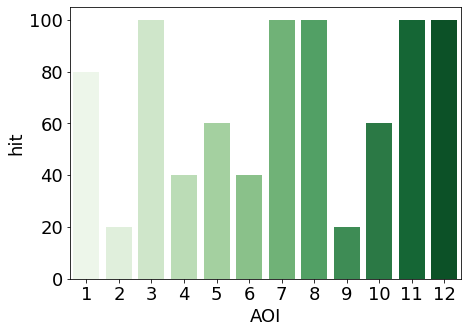

In [21]:
import seaborn as sns

hit_rate_fig, hit_rate_axs = plt.subplots(1,1, figsize = (7,5))
# Get the mean hit rate over observers and plot
proportional_hits = hits.groupby('AOI').mean().reset_index()
proportional_hits.loc[:,'hit'] =  proportional_hits['hit']*100

sns.barplot(x="AOI", y="hit", data=proportional_hits, palette = "Greens", ax = hit_rate_axs);

From this figure, we can see that some AOIs were looked at by all observers (AOI 3,7,8,11,12). Other AOIs (2, 9) were more ofte missed.

But what does that mean? Quite often, the differences how often an AOI was looked at can be explained solely by the size of the AOI: The larger it is, the more often people will look at it. This is especially important, when the recording might noisy, and AOIs might be missed because the eye tracker registers gaze at the wrong position.

We can visualize the relationship between AOI and Hit Rates in a scatter plot:

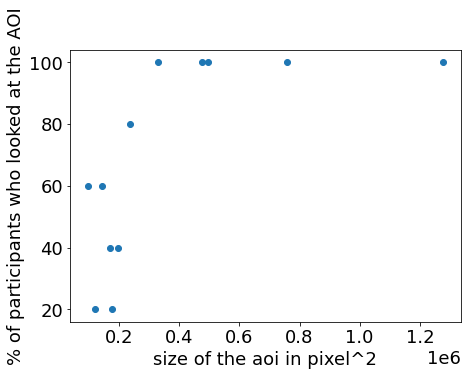

In [32]:
# compute the size of the AOI by multiplying width and length of the AOIS
aoi_size = np.array([AOI[2] * AOI[3] for AOI in aois])

size_hits_fig, size_hits_ax = plt.subplots(1,1, figsize=(7,5))
size_hits_ax.scatter(aoi_size, proportional_hits['hit'])

size_hits_ax.set_xlabel('size of the aoi in pixel^2')
size_hits_ax.set_ylabel('% of participants who looked at the AOI');

The four AOIs that were looked at by all observers are also the four largest AOIs! For the smaller AOIs, there seems to be no obvious relationship between size and hit rate. 
When you are piloting data and see "critical size" like here, keep in mind that comparing hit rates between the AOIs might not be entirely fair.

### Time to first fixation
Time to first fixation measures how long it takes an observer to look at an AOI for the first time. Short times to first contact mean that the observer looked at the AOI soon after it became visible, while long times to first contact signal that the observer was exploring other parts of the scenery before looking at the AOI in question.

We can compute time to first fixation as the difference between the time when the first fixation was registered on an AOI and the time the scenery first became visible - in this case, the time when the section started.

### Import section data

In [33]:
sections = pd.read_csv(f"{path_to_reference_image_mapper}/sections.csv")
sections.head()

,section id,recording id,recording name,wearer id,wearer name,section start time [ns],section end time [ns],start event name,end event name
0,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,SH_D_S,f5ac063b-fe37-41da-9361-22e0184f0446,SH,1636035560120000000,1636035572525000000,multiple_paintings_10sec_start,multiple_paintings_10sec_end
1,12050eb8-2135-4820-8a89-472863ef60f2,9583339a-cc7c-41ad-a242-b0db2e421866,JR_D_S,9508d4f6-e26f-48e1-b53f-051d47d27c91,JR,1635864181664000000,1635864196355000000,multiple_paintings_10sec_start,multiple_paintings_10sec_end
2,2ad6cf23-bbfb-47c4-b9cd-b9612c3327e4,b1eaf63d-a388-4c85-86a4-fa855bc4bea3,AM_D_S,ccd39285-42ae-4780-b119-042974777e7f,AM,1636382551779000000,1636382577933000000,multiple_paintings_10sec_start,multiple_paintings_10sec_end
3,57840658-7bab-4812-ad96-5f8197f2c195,c9431f2d-9299-4234-81b7-1df1e3e6e97c,SN_D_S,fb6c7332-6a81-4449-825f-57c2d77fba86,SN,1636386863776000000,1636386886095000000,multiple_paintings_10sec_start,multiple_paintings_10sec_end
4,8bf462f6-7dca-406c-80a5-0fd7604ff5e6,737e94b0-89e5-4d1b-9b06-57d84e51eaca,MT_D_S,d7c42b07-2256-4af9-96a1-22704d8b7f68,MT,1636634036249000000,1636634060648000000,multiple_paintings_10sec_start,multiple_paintings_10sec_end


### Align timestamps to section start

In [38]:
fixations['aligned timestamp [s]'] = None

for section in sections['section id']:
    section_idx = fixations[fixations['section id'] == section].index
    section_start_time = sections.loc[sections['section id'] == section, 'section start time [ns]'].values
    fixations.loc[section_idx, 'aligned timestamp [s]'] = (fixations.loc[section_idx, 'start timestamp [ns]'] - section_start_time)/1e9 

### Aggregate and extract first fixation time

In [39]:
first_contact = pd.DataFrame(fixations.groupby(['section id', 'AOI']).min()['aligned timestamp [s]'])
first_contact.reset_index(inplace = True)

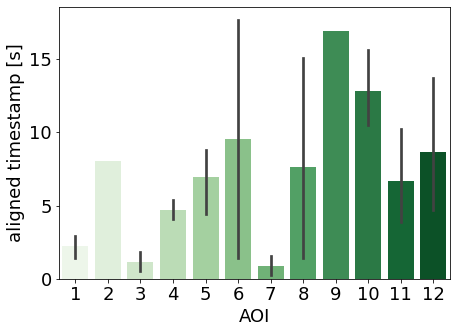

In [43]:
first_contact_fig, first_contact_ax = plt.subplots(1,1, figsize=(7,5))
sns.barplot(x="AOI", y="aligned timestamp [s]", 
            data=first_contact, palette = "Greens", 
            ci = 95, ax = first_contact_ax);

We can observe that some AOIs were looked at after short time, while other where only explored later. Comparing the plot to the hit rates above also suggests that painting with high hit rates where often explored early (e.g. AOI 7).

The confidence intervals shown in black bars give us an idea how much the time to first fixation varies between our observers - large bars (like for AOI 6 and 8) indicate that observers' times to first contact were very different. An absence of error bars (like for AOI 2 and 9) indicates that there was only one observer who looked at the AOI.

### Dwell time

Dwell time describes the total time an observer has looked at a given AOI. We can find the dwell time by summing up the durations of all fixations we detected, seperately for each AOI.

In [45]:
# add recording name for better readablity
dwell = fixations.groupby(['section id', 'AOI']).sum()['duration [ms]']
dwell = pd.DataFrame(dwell).sort_values('AOI')
dwell.reset_index(inplace = True)

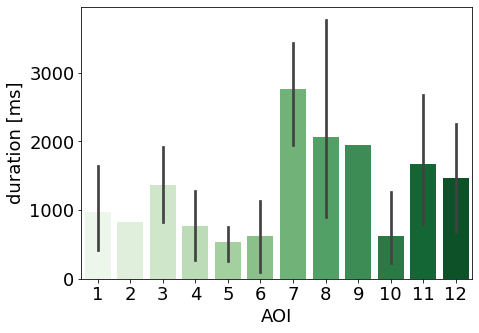

In [47]:
# plot the average time spent on each image
dwell_time_fig, dwell_time_ax = plt.subplots(1,1, figsize=(7,5))

sns.barplot(x = "AOI", y = "duration [ms]",
            data = dwell, palette = "Greens", 
            ci = 95, ax = dwell_time_ax);


Comparably to where most people looked, paintings 7,8,11 and 12 were also looked at the longest. What we can again see from the error bars, that the dwell time varies between observers.

We have looked at how we can extract AOIs inside one reference image created by the **Reference Image Mapper**. We computed 3 different metrics on the gaze data: **hit rate**, **time to first contact**, and **dwell time**.